In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Dropout, GRU, LSTM, Bidirectional, SpatialDropout1D, TextVectorization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# nltk.download('stopwords')

# def remove_english_stopwords(text):
#    stop_words = set(stopwords.words('english'))
#    word_tokens = word_tokenize(text)
#    filtered_text = [word for word in word_tokens if not word in stop_words]
#    return ' '.join(filtered_text)

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text

In [3]:
def preprocess(text):
    text = remove_nonaplhanumeric(text) 
    text = remove_unnecessary_char(text) 
#     text = remove_english_stopwords(text) 
    return text

In [4]:
train_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv',index_col='id')
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train_data['comment_text'] = train_data['comment_text'].apply(preprocess)
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0
000103f0d9cfb60f,D aww He matches this background colour I m se...,0,0,0,0,0,0
000113f07ec002fd,Hey man I m really not trying to edit war It s...,0,0,0,0,0,0
0001b41b1c6bb37e,More I can t make any real suggestions on imp...,0,0,0,0,0,0
0001d958c54c6e35,You sir are my hero Any chance you remember wh...,0,0,0,0,0,0


In [6]:
train_data['comment_length'] = train_data['comment_text'].apply(lambda row: len(row))
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
id,,,,,,,,
0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0,261
000103f0d9cfb60f,D aww He matches this background colour I m se...,0,0,0,0,0,0,103
000113f07ec002fd,Hey man I m really not trying to edit war It s...,0,0,0,0,0,0,230
0001b41b1c6bb37e,More I can t make any real suggestions on imp...,0,0,0,0,0,0,603
0001d958c54c6e35,You sir are my hero Any chance you remember wh...,0,0,0,0,0,0,64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

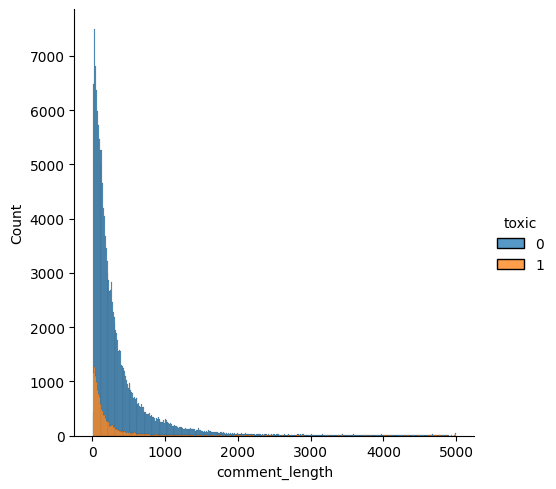

In [7]:
import seaborn as sns
sns.displot(
    data=train_data, 
    x="comment_length", 
    hue='toxic',
    multiple="stack",
)

In [8]:
toxic_data = train_data[train_data['toxic'] == 1]
toxic_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
id,,,,,,,,
0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,44
0005c987bdfc9d4b,Hey what is it talk What is it an exclusive gr...,1,0,0,0,0,0,296
0007e25b2121310b,Bye Don t look come or think of comming back T...,1,0,0,0,0,0,52
001810bf8c45bf5f,You are gay or antisemmitian Archangel WHite T...,1,0,1,0,1,1,615
00190820581d90ce,FUCK YOUR FILTHY MOTHER IN THE ASS DRY,1,0,1,0,1,0,39


In [9]:
print(
    'max', toxic_data['comment_length'].max(),
    'min', toxic_data['comment_length'].min(),
    'mean', toxic_data['comment_length'].mean(),
    'median', toxic_data['comment_length'].median(),
    '75%', toxic_data['comment_length'].quantile(0.75),
)

max 5000 min 8 mean 280.898260755852 median 118.0 75% 260.0


In [10]:
max_comment_len = 300

In [11]:
test_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv',index_col='id')
test_data.head()

,comment_text
id,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7,== From RfC == \n\n The title is fine as it is...
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
00017563c3f7919a,":If you have a look back at the source, the in..."
00017695ad8997eb,I don't anonymously edit articles at all.


In [12]:
test_labels_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv',index_col='id')
test_labels_data.head()


,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,-1,-1,-1,-1,-1,-1
0000247867823ef7,-1,-1,-1,-1,-1,-1
00013b17ad220c46,-1,-1,-1,-1,-1,-1
00017563c3f7919a,-1,-1,-1,-1,-1,-1
00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [13]:
test_data = test_data.join(test_labels_data)
test_data = test_data[test_data['toxic'] != -1]
test_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


In [14]:
num_words = 10000
encoder = TextVectorization(max_tokens=num_words)
encoder.adapt(train_data['comment_text'].values)

from tensorflow.keras.layers import BatchNormalization

model_gru = Sequential([
    encoder,
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True,
        input_length=max_comment_len,
    ),
    SpatialDropout1D(0.5),
    GRU(40, return_sequences=True),
    BatchNormalization(),
    GRU(40),
    BatchNormalization(),
    Dense(6, activation='sigmoid'),
])


In [15]:
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [16]:
model_gru_save_path = '/kaggle/working/toxic_model_gru'
checkpoint_callback_gru = ModelCheckpoint(
    model_gru_save_path, 
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    save_format='tf',
)

In [17]:
!rm -r /kaggle/working/toxic_model_gru

rm: cannot remove '/kaggle/working/toxic_model_gru': No such file or directory


In [18]:
x_train1 = train_data['comment_text'].values
y_train1 = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [19]:
from sklearn.model_selection import train_test_split 
x_train,x_val,y_train,y_val=train_test_split(x_train1,y_train1,train_size=0.8,shuffle=True,random_state=42)

In [20]:
x_train[:2]

array(['Grandma Terri Should Burn in Trash Grandma Terri is trash I hate Grandma Terri F K her to HELL 71 74 76 40',
       ' 9 May 2009 UTC It would be easiest if you were to admit to being a member of the involved Portuguese Lodge and then there would be no requirement to acknowledge whether you had a previous account Carlos Botelho did not have a good record or not and I would then remove the sockpuppet template as irrelevant WP COI permits people to edit those articles such as MSJapan does but just means you have to be more careful in ensuring that references back your edits and that NPOV is upheld 20 29'],
      dtype=object)

In [21]:
y_train[:2]

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [22]:
history_gru = model_gru.fit(
    x_train, 
    y_train, 
    epochs=5, # 15
    batch_size=512,
    validation_data=(x_val,y_val),
    callbacks=[checkpoint_callback_gru],
)

Epoch 1/5
250/250 [==============================] - ETA: 0s - loss: 0.3715 - accuracy: 0.3722 - auc: 0.8276
Epoch 1: val_accuracy improved from -inf to 0.17036, saving model to /kaggle/working/toxic_model_gru
250/250 [==============================] - 99s 346ms/step - loss: 0.3715 - accuracy: 0.3722 - auc: 0.8276 - val_loss: 0.1413 - val_accuracy: 0.1704 - val_auc: 0.9027
Epoch 2/5
250/250 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.6263 - auc: 0.9689
Epoch 2: val_accuracy improved from 0.17036 to 0.77641, saving model to /kaggle/working/toxic_model_gru
250/250 [==============================] - 68s 274ms/step - loss: 0.0707 - accuracy: 0.6263 - auc: 0.9689 - val_loss: 0.0864 - val_accuracy: 0.7764 - val_auc: 0.9363
Epoch 3/5
250/250 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.6652 - auc: 0.9836
Epoch 3: val_accuracy improved from 0.77641 to 0.79746, saving model to /kaggle/working/toxic_model_gru
250/250 [=======================

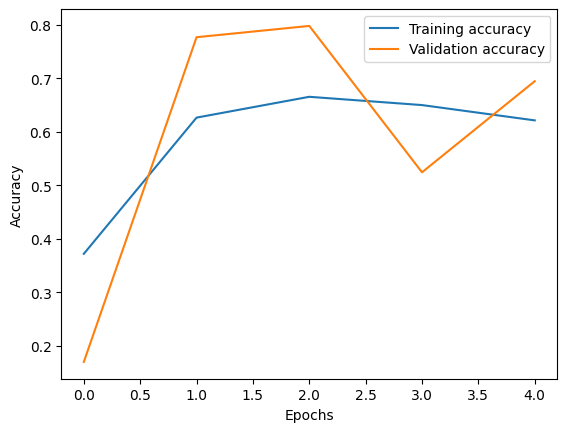

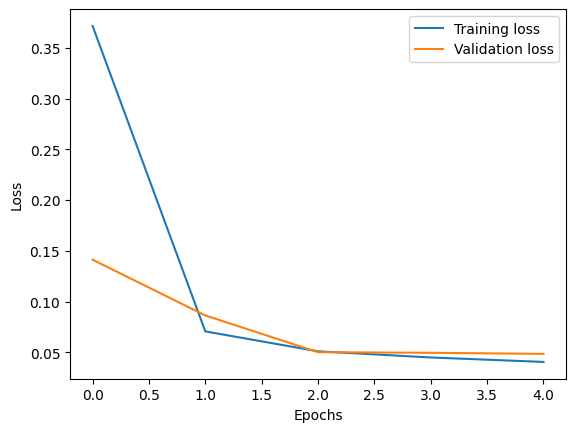

In [23]:
plt.plot(history_gru.history['accuracy'], 
         label='Training accuracy')
plt.plot(history_gru.history['val_accuracy'], 
         label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(history_gru.history['loss'], 
         label='Training loss')
plt.plot(history_gru.history['val_loss'], 
         label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
x_test = test_data['comment_text'].values
y_test = test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [25]:
model_gru.evaluate(x_test, y_test, verbose=1)

2000/2000 [==============================] - 31s 15ms/step - loss: 0.0808 - accuracy: 0.7459 - auc: 0.9720


[0.08082903921604156, 0.7458970546722412, 0.9720377922058105]

In [26]:
saved_model = load_model(model_gru_save_path)

In [27]:
test_data[test_data['toxic']==1][:5]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
00091c35fa9d0465,"== Arabs are committing genocide in Iraq, but ...",1,0,0,0,0,0
0013fed3aeae76b7,DJ Robinson is gay as hell! he sucks his dick ...,1,0,1,0,1,1
0017d4d47894af05,":Fuck off, you anti-semitic cunt. |",1,0,1,0,1,0
001d739c97bc2ae4,How dare you vandalize that page about the HMS...,1,0,0,0,0,0
001eff4007dbb65b,"::No, he is an arrogant, self serving, immatur...",1,0,1,0,1,0


In [28]:
test_data[test_data['toxic']==1][:5]['comment_text'].values

array(['== Arabs are committing genocide in Iraq, but no protests in Europe. == \n\n May Europe also burn in hell.',
       'DJ Robinson is gay as hell! he sucks his dick so much!!!!!',
       ':Fuck off, you anti-semitic cunt.  |',
       "How dare you vandalize that page about the HMS Beagle! Don't vandalize again, demon!",
       '::No, he is an arrogant, self serving, immature idiot. Get it right.'],
      dtype=object)

In [29]:
test_labels = saved_model.predict(test_data[test_data['toxic']==1][:5]['comment_text'].values)
for labels in test_labels:
    print([ round(lbl, 2) for lbl in labels])

1/1 [==============================] - 2s 2s/step
[0.5, 0.01, 0.06, 0.01, 0.06, 0.01]
[1.0, 0.18, 0.96, 0.07, 0.83, 0.18]
[1.0, 0.5, 1.0, 0.03, 0.91, 0.11]
[0.42, 0.0, 0.03, 0.01, 0.08, 0.01]
[0.98, 0.04, 0.75, 0.03, 0.56, 0.06]


In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predicts_val = saved_model.predict(x_val, verbose=1)

for threshold in thresholds:
  y_pred_val = (predicts_val > threshold)
  clr = classification_report(y_val, y_pred_val)
  f1 = f1_score(y_val, y_pred_val, average='weighted')
  precision = precision_score(y_val, y_pred_val, average='weighted')
  recall = recall_score(y_val, y_pred_val, average='weighted')
  print(f"Threshold: {threshold}\nClassification Report:\n----------------------\n{clr}\nF1 Score: {f1}\nPrecision: {precision}\nRecall: {recall}\n")


998/998 [==============================] - 14s 14ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.1
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.53      0.93      0.67      3056
           1       0.32      0.79      0.46       321
           2       0.64      0.93      0.76      1715
           3       0.16      0.15      0.16        74
           4       0.54      0.90      0.68      1614
           5       0.21      0.41      0.28       294

   micro avg       0.53      0.89      0.66      7074
   macro avg       0.40      0.68      0.50      7074
weighted avg       0.53      0.89      0.66      7074
 samples avg       0.07      0.09      0.07      7074

F1 Score: 0.664456265701898
Precision: 0.5341997699263881
Recall: 0.8856375459428895

Threshold: 0.2
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.67      0.88      0.76      3056
           1       0.41      0.61      0.49       321
           2       0.74      0.8

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: Unde

Threshold: 0.4
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      3056
           1       0.58      0.35      0.44       321
           2       0.84      0.79      0.81      1715
           3       0.00      0.00      0.00        74
           4       0.75      0.68      0.71      1614
           5       1.00      0.02      0.03       294

   micro avg       0.80      0.70      0.75      7074
   macro avg       0.66      0.44      0.47      7074
weighted avg       0.79      0.70      0.73      7074
 samples avg       0.07      0.07      0.06      7074

F1 Score: 0.7252873579497912
Precision: 0.7913612942410002
Recall: 0.702572801809443

Threshold: 0.5
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.85      0.75      0.80      3056
           1       0.60      0.21      0.31       321
           2       0.86      0.7

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: Unde

In [31]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predicts = saved_model.predict(x_test, verbose=1)

for threshold in thresholds:
  y_pred = (predicts > threshold)
  f1 = f1_score(y_test, y_pred, average='weighted')
  clr = classification_report(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  print(f"Threshold: {threshold}\nClassification Report:\n----------------------\n{clr}\nF1 Score: {f1}\nPrecision: {precision}\nRecall: {recall}\n")

2000/2000 [==============================] - 27s 14ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.1
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.34      0.95      0.50      6090
           1       0.17      0.80      0.28       367
           2       0.40      0.92      0.55      3691
           3       0.28      0.21      0.24       211
           4       0.35      0.90      0.51      3427
           5       0.26      0.48      0.34       712

   micro avg       0.35      0.89      0.50     14498
   macro avg       0.30      0.71      0.40     14498
weighted avg       0.35      0.89      0.50     14498
 samples avg       0.07      0.09      0.07     14498

F1 Score: 0.49949941931159747
Precision: 0.3493464309573636
Recall: 0.8928128017657608

Threshold: 0.2
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.43      0.92      0.58      6090
           1       0.24      0.64      0.35       367
           2       0.51      0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.3
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.48      0.89      0.62      6090
           1       0.28      0.47      0.35       367
           2       0.58      0.82      0.68      3691
           3       0.22      0.01      0.02       211
           4       0.55      0.73      0.63      3427
           5       0.62      0.04      0.08       712

   micro avg       0.51      0.77      0.61     14498
   macro avg       0.45      0.49      0.40     14498
weighted avg       0.52      0.77      0.59     14498
 samples avg       0.07      0.07      0.07     14498

F1 Score: 0.5945147825797282
Precision: 0.5176153405904703
Recall: 0.7704510967029935

Threshold: 0.4
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.52      0.86      0.65      6090
           1       0.32      0.34      0.33       367
           2       0.64      0.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.5
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.56      0.82      0.67      6090
           1       0.37      0.21      0.27       367
           2       0.69      0.72      0.71      3691
           3       0.00      0.00      0.00       211
           4       0.70      0.58      0.63      3427
           5       0.57      0.01      0.01       712

   micro avg       0.61      0.67      0.64     14498
   macro avg       0.48      0.39      0.38     14498
weighted avg       0.61      0.67      0.62     14498
 samples avg       0.07      0.06      0.07     14498

F1 Score: 0.6167694300786418
Precision: 0.6136433231542712
Recall: 0.6722996275348324

Threshold: 0.6
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.60      0.79      0.68      6090
           1       0.48      0.10      0.16       367
           2       0.74      0.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.7
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.65      0.74      0.69      6090
           1       0.36      0.01      0.02       367
           2       0.79      0.61      0.69      3691
           3       0.00      0.00      0.00       211
           4       0.81      0.41      0.55      3427
           5       1.00      0.00      0.01       712

   micro avg       0.71      0.56      0.63     14498
   macro avg       0.60      0.30      0.33     14498
weighted avg       0.72      0.56      0.60     14498
 samples avg       0.07      0.05      0.06     14498

F1 Score: 0.5956196459287735
Precision: 0.7232405135071405
Recall: 0.5635260035867016

Threshold: 0.8
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.71      0.67      0.69      6090
           1       0.00      0.00      0.00       367
           2       0.84      0.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

In [32]:
!zip -r /kaggle/working/toxic_model_gru.zip /kaggle/working/toxic_model_gru

  adding: kaggle/working/toxic_model_gru/ (stored 0%)
  adding: kaggle/working/toxic_model_gru/saved_model.pb (deflated 89%)
  adding: kaggle/working/toxic_model_gru/variables/ (stored 0%)
  adding: kaggle/working/toxic_model_gru/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: kaggle/working/toxic_model_gru/variables/variables.index (deflated 65%)
  adding: kaggle/working/toxic_model_gru/keras_metadata.pb (deflated 90%)
  adding: kaggle/working/toxic_model_gru/fingerprint.pb (stored 0%)
  adding: kaggle/working/toxic_model_gru/assets/ (stored 0%)
